In [1]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers, optimizers
import numpy as np

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

"""
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 
training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains 
exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random 
order, but some training batches may contain more images from one class than another. Between them, the training 
batches contain exactly 5000 images from each class.
"""


def unpickle(file):
    """load the cifar-10 data"""

    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


def load_cifar_10_data(data_dir, negatives=False):
    """
    Return train_data, train_filenames, train_labels, test_data, test_filenames, test_labels
    """

    # get the meta_data_dict
    # num_cases_per_batch: 1000
    # label_names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    # num_vis: :3072

    meta_data_dict = unpickle(data_dir + "/batches.meta")
    #meta_data_dict = "/content/drive/MyDrive/ColabNotebooks/SOP/cifar-10-batches-py/batches.meta"
    cifar_label_names = meta_data_dict[b'label_names']
    cifar_label_names = np.array(cifar_label_names)

    # training data
    cifar_train_data = None
    cifar_train_filenames = []
    cifar_train_labels = []

    # cifar_train_data_dict
    # 'batch_label': 'training batch 5 of 5'
    # 'data': ndarray
    # 'filenames': list
    # 'labels': list

    for i in range(1, 6):
        cifar_train_data_dict = unpickle(data_dir + "/data_batch_{}".format(i))
        if i == 1:
            cifar_train_data = cifar_train_data_dict[b'data']
        else:
            cifar_train_data = np.vstack((cifar_train_data, cifar_train_data_dict[b'data']))
        cifar_train_filenames += cifar_train_data_dict[b'filenames']
        cifar_train_labels += cifar_train_data_dict[b'labels']

    cifar_train_data = cifar_train_data.reshape((len(cifar_train_data), 3, 32, 32))
    if negatives:
        cifar_train_data = cifar_train_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_train_data = np.rollaxis(cifar_train_data, 1, 4)
    cifar_train_filenames = np.array(cifar_train_filenames)
    cifar_train_labels = np.array(cifar_train_labels)

    # test data
    # cifar_test_data_dict
    # 'batch_label': 'testing batch 1 of 1'
    # 'data': ndarray
    # 'filenames': list
    # 'labels': list

    cifar_test_data_dict = unpickle(data_dir + "/test_batch")
    cifar_test_data = cifar_test_data_dict[b'data']
    cifar_test_filenames = cifar_test_data_dict[b'filenames']
    cifar_test_labels = cifar_test_data_dict[b'labels']

    cifar_test_data = cifar_test_data.reshape((len(cifar_test_data), 3, 32, 32))
    if negatives:
        cifar_test_data = cifar_test_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_test_data = np.rollaxis(cifar_test_data, 1, 4)
    cifar_test_filenames = np.array(cifar_test_filenames)
    cifar_test_labels = np.array(cifar_test_labels)

    return cifar_train_data, cifar_train_filenames, cifar_train_labels, \
        cifar_test_data, cifar_test_filenames, cifar_test_labels, cifar_label_names

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
 import sys
 sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks/SOP')
 cifar_10_dir = "/content/drive/MyDrive/ColabNotebooks/SOP/cifar-10-batches-py"
 train_data, train_filenames, train_labels, test_data, test_filenames, test_labels, label_names =  load_cifar_10_data(cifar_10_dir)

In [7]:
train_x_orig, train_y_orig, test_x_orig, test_y_orig, classes = train_data, train_labels, test_data, test_labels, label_names

y = 7. It's a horse picture.


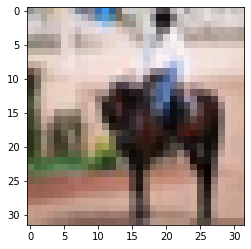

In [8]:
# Example of a picture
index = 11
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y_orig[index]) + ". It's a " + classes[train_y_orig[index]].decode("utf-8") +  " picture.")

In [9]:
train_x_temp = train_x_orig
print(train_x_temp.shape)

test_x_temp = test_x_orig
print(test_x_temp.shape)

train_y_temp = train_y_orig
print(train_y_temp.shape)

test_y_temp = test_y_orig
print(test_y_temp.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000,)
(10000,)


In [10]:
'''train_x_temp = train_x_orig[: 10000, :, :, :]
print(train_x_temp.shape)

test_x_temp = test_x_orig[: 1000, :, :, :]
print(test_x_temp.shape)

train_y_temp = train_y_orig[: 10000]
print(train_y_temp.shape)

test_y_temp = test_y_orig[: 1000]
print(test_y_temp.shape)'''

'train_x_temp = train_x_orig[: 10000, :, :, :]\nprint(train_x_temp.shape)\n\ntest_x_temp = test_x_orig[: 1000, :, :, :]\nprint(test_x_temp.shape)\n\ntrain_y_temp = train_y_orig[: 10000]\nprint(train_y_temp.shape)\n\ntest_y_temp = test_y_orig[: 1000]\nprint(test_y_temp.shape)'

In [11]:
# Explore your dataset 
m_train = train_x_temp.shape[0]
num_px = train_x_temp.shape[1]
m_test = test_x_temp.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_temp shape: " + str(train_x_temp.shape))
print ("train_y_temp shape: " + str(train_y_temp.shape))
print ("test_x_temp shape: " + str(test_x_temp.shape))
print ("test_y_temp shape: " + str(test_y_temp.shape))

Number of training examples: 50000
Number of testing examples: 10000
Each image is of size: (32, 32, 3)
train_x_temp shape: (50000, 32, 32, 3)
train_y_temp shape: (50000,)
test_x_temp shape: (10000, 32, 32, 3)
test_y_temp shape: (10000,)


In [12]:
# Reshape the training and test examples 
train_x_flatten = train_x_temp.reshape(train_x_temp.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_temp.reshape(test_x_temp.shape[0], -1).T


# convert from integers to floats
train_norm = train_x_flatten.astype('float32')
test_norm = test_x_flatten.astype('float32')

# Standardize data to have feature values between 0 and 1.
train_x = train_norm/255.0
test_x = test_norm/255.0

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (3072, 50000)
test_x's shape: (3072, 10000)


In [13]:
#converts into categorical type
def one_hot(arr, num_classes):
    return np.squeeze(np.eye(num_classes)[arr.reshape(-1)])

In [14]:
train_y_categorical = one_hot(train_y_temp,10)
train_y = np.transpose(train_y_categorical)

test_y_categorical = one_hot(test_y_temp,10)
test_y = np.transpose(test_y_categorical)

In [15]:
print(train_y.shape)
print(test_y.shape)

(10, 50000)
(10, 10000)


## 5 - L-layer Neural Network
The functions you needed and their inputs are:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [16]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [17]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def stable_softmax(Z):
    exps = np.exp(X - np.max(X))
    return exps / np.sum(exps),Z



In [18]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache


In [19]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [20]:
nx = np.size(label_names)

In [21]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (nx,X.shape[1]))
            
    return AL, caches


In [22]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cross_entropy_cost = (-1./m) * (np.sum(np.multiply(Y,np.log(AL)))+np.sum(np.multiply(1-Y,np.log(1-AL))))
    
    cross_entropy_cost = np.squeeze(cross_entropy_cost)     
    assert(cross_entropy_cost.shape == ())
    
    return cross_entropy_cost

In [23]:
def linear_backward(dZ, cache):
    """
     # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1./m) * np.dot(dZ,A_prev.T)
    db = (1./m) * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db



In [24]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [25]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
                the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - np.divide(Y, AL) + np.divide(1-Y,1-AL)
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [26]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

In [27]:
### CONSTANTS ###
layers_dims = [3072, 20, 15,12, 10] #  4-layer model

In [34]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.001, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches =  L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 10 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 10 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 6.952997
Cost after iteration 10: 6.631359
Cost after iteration 20: 6.511911
Cost after iteration 30: 6.386736
Cost after iteration 40: 6.266076
Cost after iteration 50: 6.156959
Cost after iteration 60: 6.049166
Cost after iteration 70: 5.935306
Cost after iteration 80: 5.814299
Cost after iteration 90: 5.685916
Cost after iteration 100: 5.550211
Cost after iteration 110: 5.407607
Cost after iteration 120: 5.258993
Cost after iteration 130: 5.105733
Cost after iteration 140: 4.949378
Cost after iteration 150: 4.791896
Cost after iteration 160: 4.635992
Cost after iteration 170: 4.484921
Cost after iteration 180: 4.342192
Cost after iteration 190: 4.211084


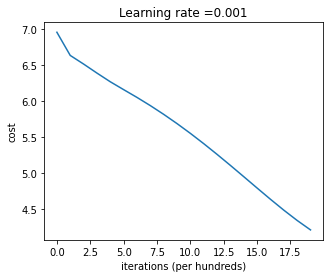

In [35]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 200, print_cost = True)

In [36]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1, m),dtype=int)
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)
    
    count=0
    # convert probas to 0/1 predictions
    p = np.argmax(probas,axis=0)
    '''for i in range(0, probas.shape[1]):
        p[i]=np.argmax(probas,axis=0)
        if (y[arg,i]==float(1)):
            count=count+1'''

    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print(np.sum(p==y))
    print(p.shape)
    #print(count)
    print("Accuracy: %s" % str(np.sum(p == y)/float(m)))
        
    #return p

In [ ]:
pred_train = predict(train_x, train_y_temp, parameters)

In [ ]:
pred_test = predict(test_x, test_y_temp, parameters)